In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import os 
from sklearn.utils import class_weight 

In [39]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 10
lr = 0.003

In [31]:
# Set the paths to the training, test and validation data directories
train_dir = 'data/MSID_US_SP/train'
val_dir = 'data/MSID_US_SP/val'

In [32]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)



Found 300 images belonging to 4 classes.
Found 85 images belonging to 4 classes.


In [37]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer to reduce the spatial dimensions of the output of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with the number of units equal to the number of classes for the final prediction
predictions = Dense(num_classes, activation='softmax')(x)

# Create a new model with the input layer of the MobileNetV2 model and the output layer of the fully connected layer
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the MobileNetV2 model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False


optimizier = tf.keras.optimizers.Adam(learning_rate=lr)


# Compile the model
model.compile(optimizer=optimizier,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [34]:
history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=val_generator)

Epoch 1/5
10/10 [==============================] - 5s 442ms/step - loss: 1.4129 - accuracy: 0.4233 - val_loss: 1.0161 - val_accuracy: 0.6000
Epoch 2/5
10/10 [==============================] - 4s 350ms/step - loss: 0.6941 - accuracy: 0.7433 - val_loss: 0.6748 - val_accuracy: 0.7647
Epoch 3/5
10/10 [==============================] - 4s 354ms/step - loss: 0.4955 - accuracy: 0.8167 - val_loss: 0.6187 - val_accuracy: 0.7882
Epoch 4/5
10/10 [==============================] - 4s 354ms/step - loss: 0.3566 - accuracy: 0.8933 - val_loss: 0.5888 - val_accuracy: 0.8118
Epoch 5/5
10/10 [==============================] - 4s 352ms/step - loss: 0.2646 - accuracy: 0.9233 - val_loss: 0.5246 - val_accuracy: 0.8235


In [35]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, batch_size=batch_size)
print('Test loss:', test_loss)

print('Test accuracy:', test_acc)

17/17 [==============================] - 5s 272ms/step - loss: 0.4343 - accuracy: 0.8522
Test loss: 0.43425196409225464
Test accuracy: 0.8522073030471802


In [36]:
# mobilemiracle = tf.keras.models.load_model('models/mobilenetv2_model.h5')

Found 521 images belonging to 4 classes.
521/521 [==============================] - 8s 14ms/step


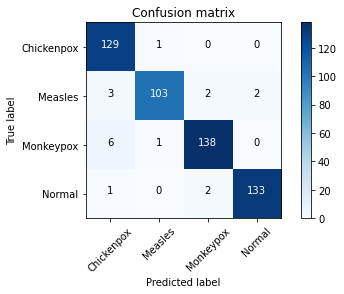

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_dir = 'data/MSID_US_AUG_SP/test'

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle= False
)

# Use the test generator to generate predictions
Y_pred = mobilemiracle.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define the class names
class_names = list(test_generator.class_indices.keys())

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='Confusion matrix')
plt.show()


In [31]:
# model.save('models/mobilemiracle.h5')

In [12]:
import cv2

# image = cv2.imread('data/MSID/Measles/measles1.png')

image = cv2.imread('chickenpox-test.jpeg')

# Resize the image to the input size expected by the model
input_size = (224, 224)  # example input size for a model
image = cv2.resize(image, input_size)

# Convert the image to a NumPy array
image = np.array(image)

# Scale the pixel values to be between 0 and 1
image = image / 255.0

# Add an extra dimension to the array to represent the batch size (1 in this case)
image = np.expand_dims(image, axis=0)

# assuming your preprocessed image is stored in a variable named 'preprocessed_image'
prediction = mobilemiracle.predict(image)

predicted_class = np.argmax(prediction)


print(predicted_class)

[ WARN:0@0.055] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('chickenpox-test.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
